# Import all necessary packages

In [2]:
import pandas as pd
import numpy as np
import os
#from keras.preprocessing import image
from keras.utils import to_categorical
import shutil
import cv2
import matplotlib.pyplot as plt
import math
import random
from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping


# images pre processing

In [3]:
def select_contour_with_least_bright_colors(contours, img_rgb):
    # Filter outlines based on your area
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 100000]
    
    # If there are no contours after the filter, return None
    if not filtered_contours:
        return None
    
    # Calculate the proportion of light colors for each contour    
    brightness_scores = []
    for contour in filtered_contours:
        mask = np.zeros(img_rgb.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
        
        # Get the pixels of the original image that are inside the contour
        pixels_inside_contour = cv2.bitwise_and(img_rgb, img_rgb, mask=mask)
        
        # Calculate the average of the sum of the values ​​of channels R, G and B
        mean_brightness = np.mean(pixels_inside_contour[pixels_inside_contour > 0])
        brightness_scores.append(mean_brightness)
    
    # Select the contour with the lowest proportion of light colors
    desired_contour = filtered_contours[np.argmin(brightness_scores)]
    
    return desired_contour


def process_image(img_entry):  
   
    # read images in grey scale
    gray = cv2.cvtColor(img_entry, cv2.COLOR_BGR2GRAY)
           
    # Threshold adaptativo    
    _, thresh = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY)

    # Opening and closing operations to improve contours and reduce noise
    kernel = np.ones((5,5),np.uint8)
    result = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    inverted_image = cv2.bitwise_not(result)    
    contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Select a maximum of 10 objects with larger areas
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] 

    # Select the contour with the lowest proportion of light colors
    selected_contour = select_contour_with_least_bright_colors(contours, img_entry)

    M = cv2.moments(selected_contour)
    if M['mu02'] != 0:
        fish_angle = 0.5 * math.atan2(2 * M['mu11'], (M['mu20'] - M['mu02']))
        fish_angle = math.degrees(fish_angle)  # converter para graus
    else:
        fish_angle = 0
    
    # Create a mask
    mask = np.zeros_like(gray)   
    cv2.drawContours(mask, [selected_contour], -1, (255), thickness=cv2.FILLED)

    # Apply the mask to the original image
    masked_img = cv2.bitwise_and(img_entry, img_entry, mask=mask)

    # Create an all-white image the same size as the original image
    white_img = np.ones_like(img_entry) * 255

    # Inverter to mask
    inverse_mask = cv2.bitwise_not(mask)

    # Apply the inverted mask to the white image
    white_background = cv2.bitwise_and(white_img, white_img, mask=inverse_mask)

    # Match the white background image to the masked image
    final_img = cv2.add(masked_img, white_background)

    # Convert to RGB
    image_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    return image_rgb, fish_angle

# automatically separate images based on metadata file

In [4]:
# Read CSV file
df = pd.read_csv(r"C:\Users\marcio\Documents\tulane_filtered_multimedia.csv")

# Create a dictionary mapping ARKID to scientificName
arkid_to_class = dict(zip(df['ARKID'], df['scientificName']))

# Image directory
image_dir = "C:/Users/marcio/Documents/tulane_images"  

# Iterate over the files in the images folder
for filename in os.listdir(image_dir):
    # Get file name without extension
    base_name = os.path.splitext(filename)[0]
    
    # Get the class using the dictionary
    image_class = arkid_to_class.get(base_name)
    
    if image_class:
        # Class folder path
        class_dir = os.path.join(image_dir, image_class)
        
        # If the class folder does not exist, create
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        
        # Move the image to the class folder
        src_path = os.path.join(image_dir, filename)
        dst_path = os.path.join(class_dir, filename)
        shutil.move(src_path, dst_path)

# Function to rotate images (pre processing steps)

In [5]:
def load_images_from_folder(folder):
    images = []
    labels = []
    label_dict = {}
    current_label = 0
    
    for subdir in os.listdir(folder):
        subdir_path = os.path.join(folder, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                
                img = cv2.imread(os.path.join(subdir_path, filename))

                # delete ruler and tag
                img, fish_angle = process_image(img)
                
                # resize the image
                img = cv2.resize(img, (128, 128)) #128
                
                # rotate the image to make the fish straight
                (h, w) = img.shape[:2]
                center = (w // 2, h // 2)
                rotation_matrix = cv2.getRotationMatrix2D(center, fish_angle, 1)
                rotated = cv2.warpAffine(img, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))                 
                                
                # normalize the image [0-1]
                img_norm = rotated / 255.0

                images.append(img_norm)   
                             
                # atribute or add label
                if subdir not in label_dict:
                    label_dict[subdir] = current_label
                    current_label += 1
                labels.append(label_dict[subdir])
                    
    return np.array(images), np.array(labels), label_dict

In [6]:
# Specify the folder path and load images along with their labels using the previously defined function

folder_path = "C:/Users/marcio/Documents/tulane_images/"  
images, labels, label_dict = load_images_from_folder(folder_path)

In [7]:
label_dict

{'Cyprinus carpio': 0,
 'Esox americanus': 1,
 'Lepomis megalotis': 2,
 'Notropis atherinoides': 3,
 'Notropis buccatus': 4}

In [8]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

# function to make bright adjustments (image pre processing)

In [9]:
def custom_brightness_adjustment(image):
    """
    Adjust the brightness of an image randomly by 10% less,
    excluding pixels with a value of 1.0.
    
    Parameters:
        image (np.array): The input image as a NumPy array.
        
    Returns:
        np.array: The adjusted image as a NumPy array.
    """
    # Generate a random brightness factor between 0.9 and 1.1
    brightness_factor = random.uniform(0.9, 1)
    
    # Create a mask of pixels that are not 1.0
    mask = image != 1.0
    
    # Apply the brightness factor only to pixels in the mask
    adjusted_image = np.copy(image)
    adjusted_image[mask] = adjusted_image[mask] * brightness_factor
    
    # Clip the values to be in valid range [0, 1]
    adjusted_image = np.clip(adjusted_image, 0, 1)
    
    return adjusted_image

In [10]:
X = np.expand_dims(images, axis=-1)  # add one more dimension to arrays (num_images, 128, 128, 1)
y = to_categorical(labels)
num_classes = len(label_dict)

# Create the model, prepare cros-validation setup, and run the models using callback for early stopping to avoid over fitting

In [11]:
# Define the model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# parameters
n_splits = 5
batch_size = 10
epochs = 150

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

# lists to store metrics in each folder
scores = []
histories = []
models = []

# Loop for each fold
for train_index, val_index in kfold.split(X, labels):
    # Dividindo os dados
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Data augmentation only in train data
    train_datagen = ImageDataGenerator(
        preprocessing_function=custom_brightness_adjustment, 
        rotation_range=5,        # Rotação aleatória de até 5 graus
        width_shift_range=0.1,    # Deslocamento horizontal aleatório
        height_shift_range=0.05,   # Deslocamento vertical aleatório   
        zoom_range=0.05,           # apply zoom    
        horizontal_flip=False,     # Inverter aleatoriamente as imagens horizontalmente
        vertical_flip=False,
        fill_mode='nearest'       # Modo de preenchimento para áreas fora da imagem original
    )
    val_datagen = ImageDataGenerator(
        # nothing to do with test data, as all images were already pre processed
    )
    
    # create the generators
    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

    # compile the model
    model = create_model()    

    #implement the early stopping for avoiding over fitting
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
    
    # train model using generators
    history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
    
    models.append(model)    
    histories.append(history)

    # evaluate the models and storing the data 
    score = model.evaluate(val_generator, verbose=1)
    scores.append(score)


# Calculating average of metrics
mean_loss = np.mean([score[0] for score in scores])
mean_accuracy = np.mean([score[1] for score in scores])

median_loss = np.median([score[0] for score in scores])
median_accuracy = np.median([score[1] for score in scores])

Epoch 1/150
8/8 [==============================] - 5s 474ms/step - loss: 2.2349 - accuracy: 0.1375 - val_loss: 1.6070 - val_accuracy: 0.2000
Epoch 2/150
8/8 [==============================] - 3s 323ms/step - loss: 1.6133 - accuracy: 0.1875 - val_loss: 1.5937 - val_accuracy: 0.4000
Epoch 3/150
8/8 [==============================] - 4s 441ms/step - loss: 1.5928 - accuracy: 0.3125 - val_loss: 1.5508 - val_accuracy: 0.4000
Epoch 4/150
8/8 [==============================] - 3s 364ms/step - loss: 1.5734 - accuracy: 0.2875 - val_loss: 1.4955 - val_accuracy: 0.2000
Epoch 5/150
8/8 [==============================] - 3s 339ms/step - loss: 1.4956 - accuracy: 0.2875 - val_loss: 1.2747 - val_accuracy: 0.6500
Epoch 6/150
8/8 [==============================] - 3s 417ms/step - loss: 1.3160 - accuracy: 0.4125 - val_loss: 1.1028 - val_accuracy: 0.6000
Epoch 7/150
8/8 [==============================] - 5s 649ms/step - loss: 1.3699 - accuracy: 0.4000 - val_loss: 1.1202 - val_accuracy: 0.5500
Epoch 8/150
8

# Print the metrics for cros-validation



In [12]:

print(f'average loss of all {n_splits} folds: {mean_loss:.4f}')
print(f'average accuracy of all {n_splits} folds: {mean_accuracy:.4f}')

print(f'median loss of all {n_splits} folds: {median_loss:.4f}')
print(f'median accuracy of all {n_splits} folds: {median_accuracy:.4f}')

print(f'individual loss for each one of the {n_splits} folds: {[round(score[0], 2) for score in scores]}')
print(f'individual accuracy for each one of the {n_splits} folds: {[round(score[1], 2) for score in scores]}')




average loss of all 5 folds: 0.5710
average accuracy of all 5 folds: 0.7800
median loss of all 5 folds: 0.5987
median accuracy of all 5 folds: 0.7500
individual loss for each one of the 5 folds: [0.39, 0.67, 0.44, 0.6, 0.76]
individual accuracy for each one of the 5 folds: [0.9, 0.8, 0.75, 0.75, 0.7]


# Plot training graphics for the 5 different models


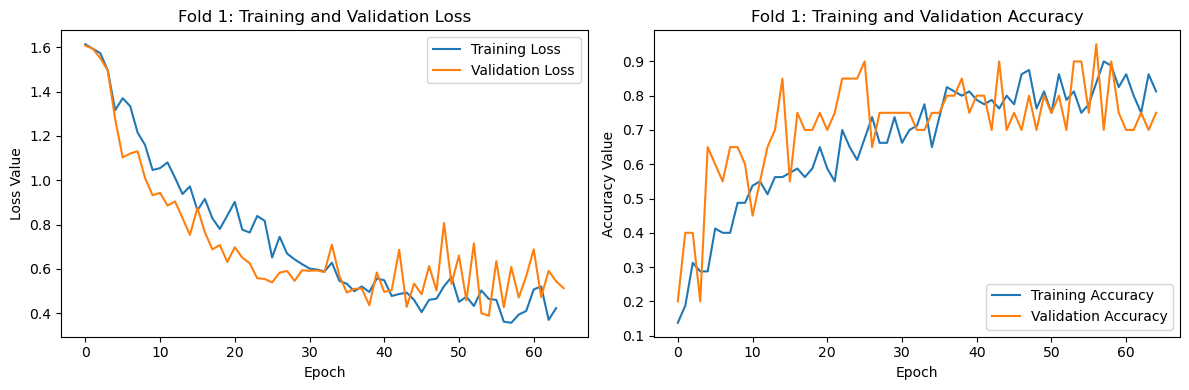

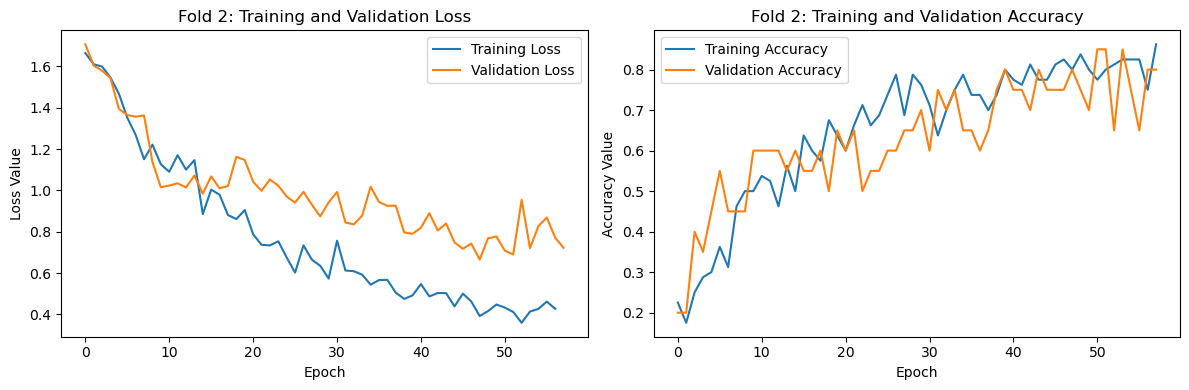

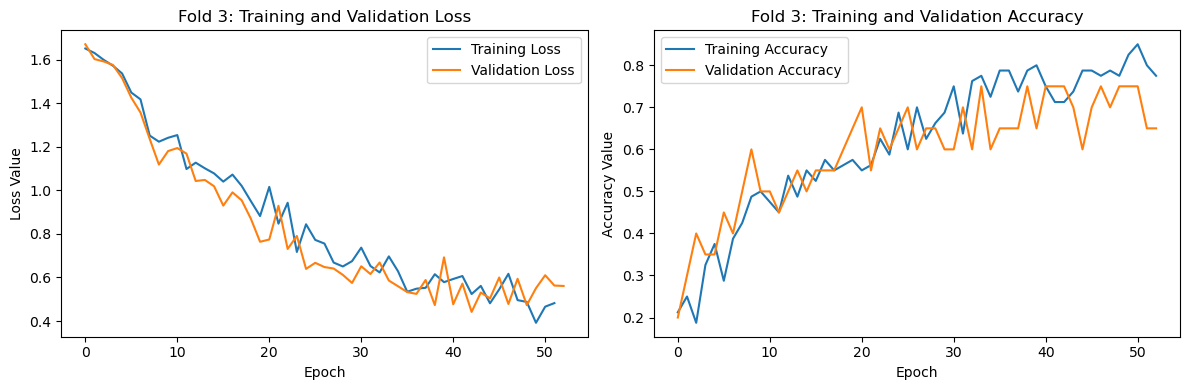

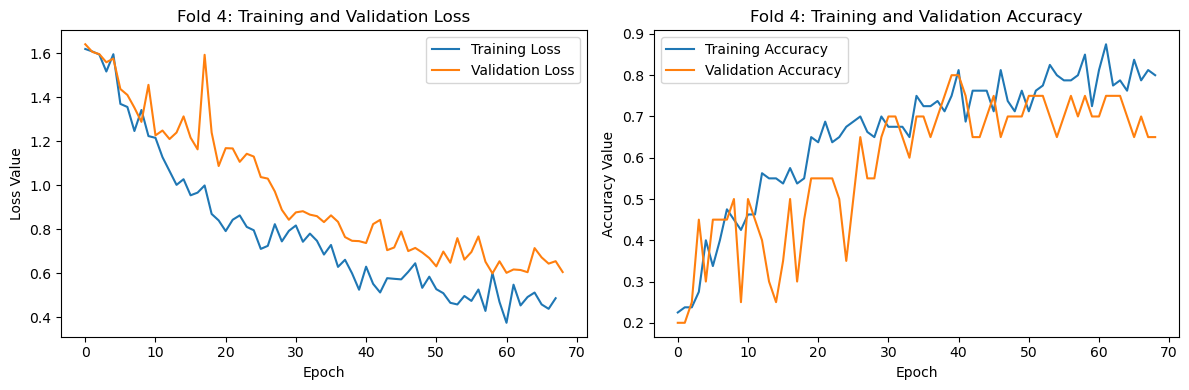

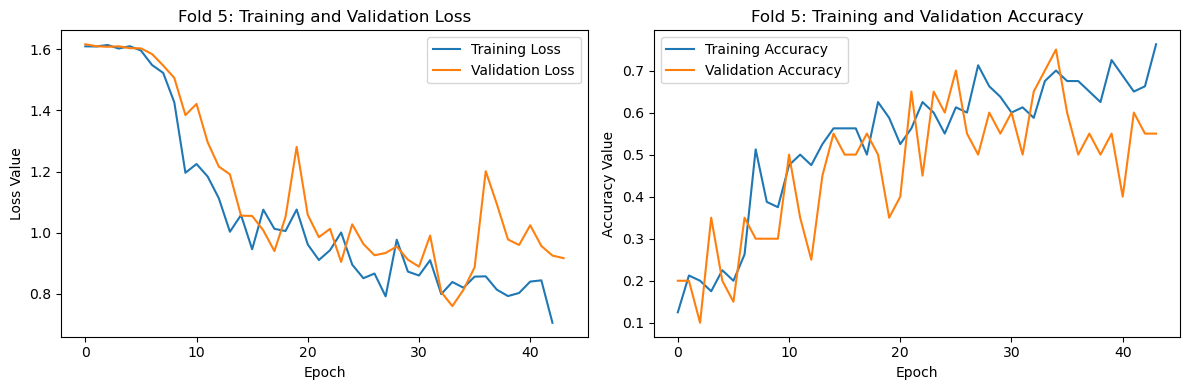

In [13]:
# initialize a counter
fold_number = 1

for history in histories:
    
    # plot training and validation loss
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'][1:], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_number}: Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.legend()

    # Plotar train and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold_number}: Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Value')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # increment the counter
    fold_number += 1


# Confusion matrix and pictures of misclassification of fish for each model (fold)

1/1 [==============================] - 0s 134ms/step

Model 1 accuracy: 95.00%
Accuracy by class:
Cyprinus carpio: 100.00%
Esox americanus: 100.00%
Lepomis megalotis: 100.00%
Notropis atherinoides: 75.00%
Notropis buccatus: 100.00%


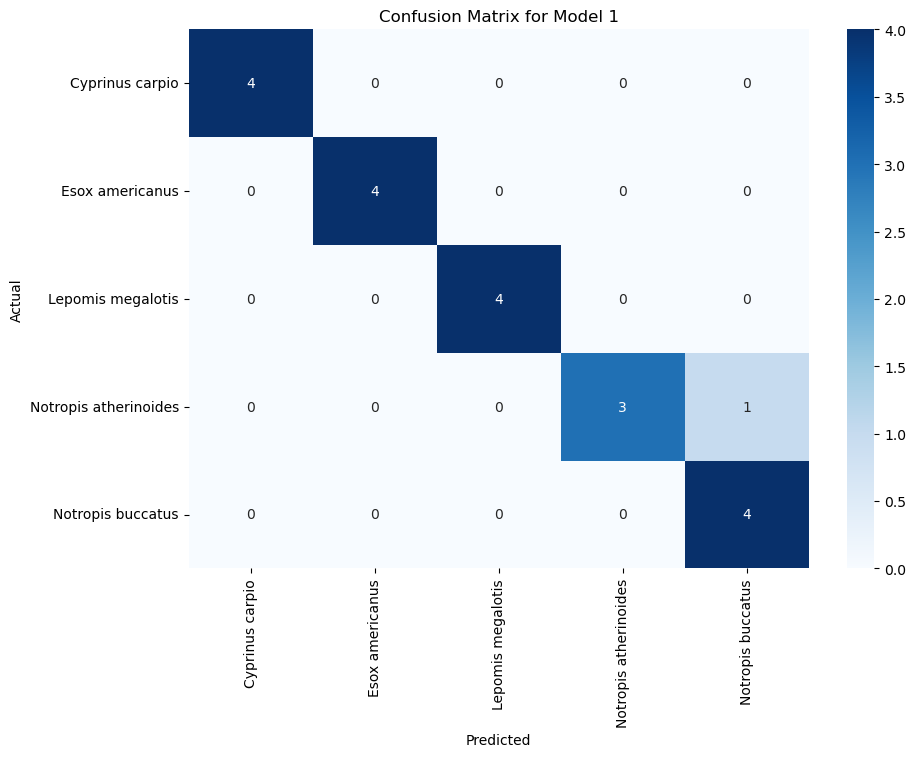

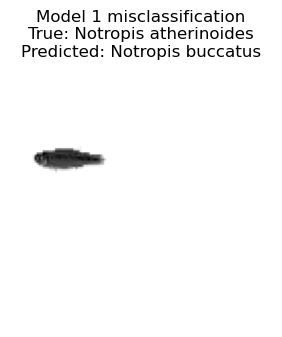

1/1 [==============================] - 0s 103ms/step

Model 2 accuracy: 90.00%
Accuracy by class:
Cyprinus carpio: 100.00%
Esox americanus: 100.00%
Lepomis megalotis: 100.00%
Notropis atherinoides: 50.00%
Notropis buccatus: 100.00%


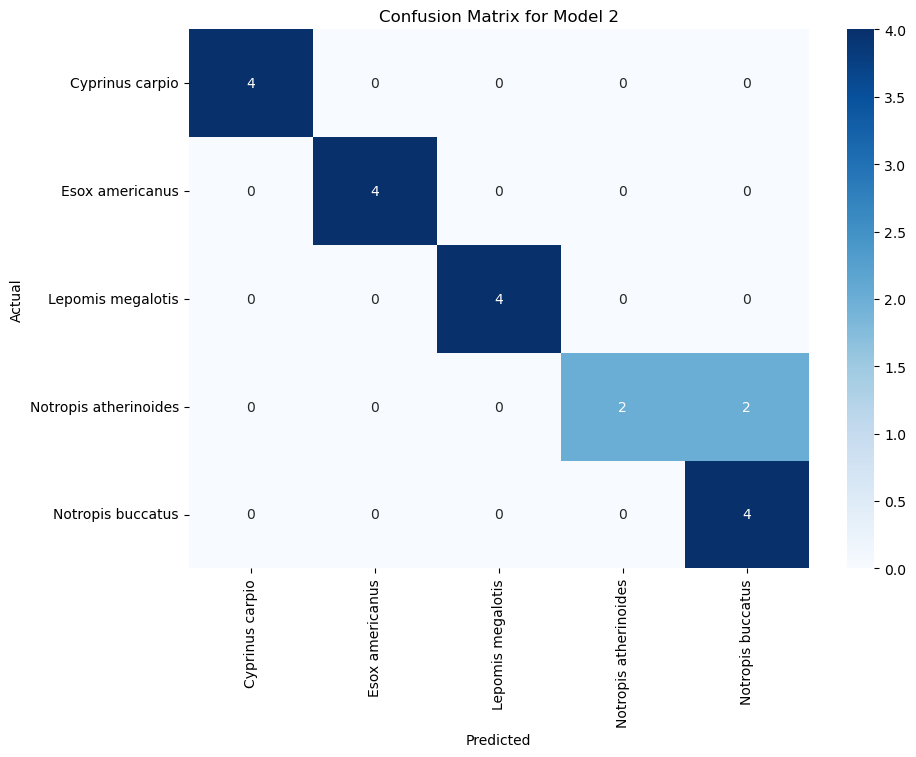

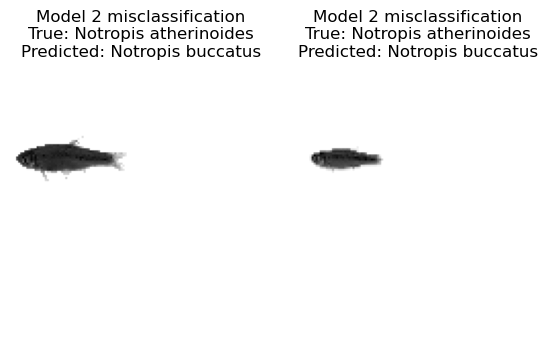

1/1 [==============================] - 0s 106ms/step

Model 3 accuracy: 80.00%
Accuracy by class:
Cyprinus carpio: 100.00%
Esox americanus: 100.00%
Lepomis megalotis: 50.00%
Notropis atherinoides: 50.00%
Notropis buccatus: 100.00%


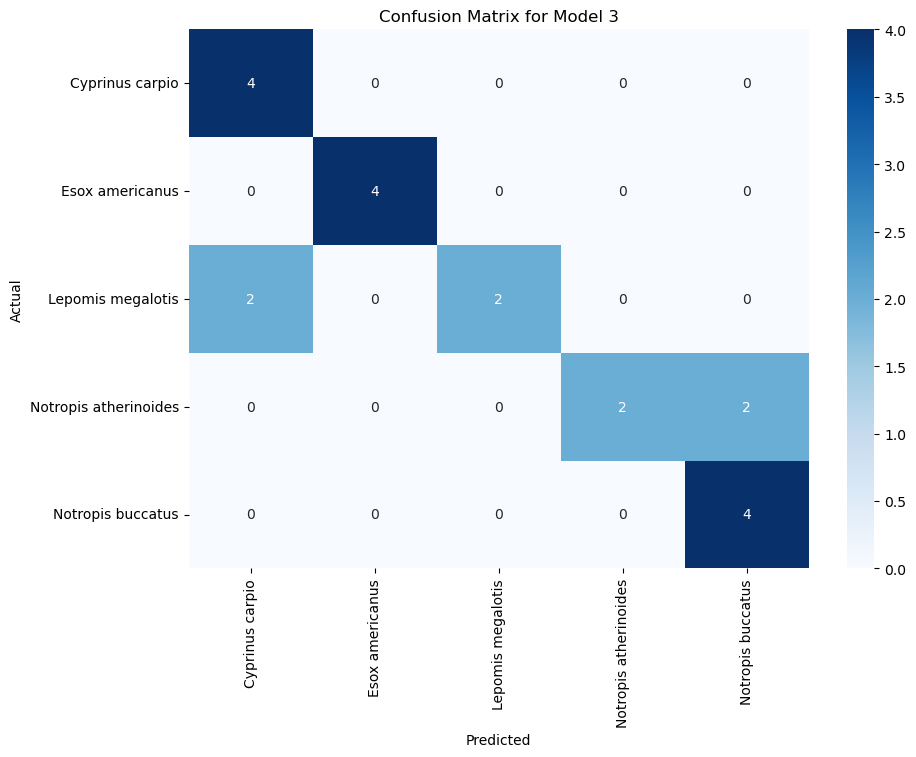

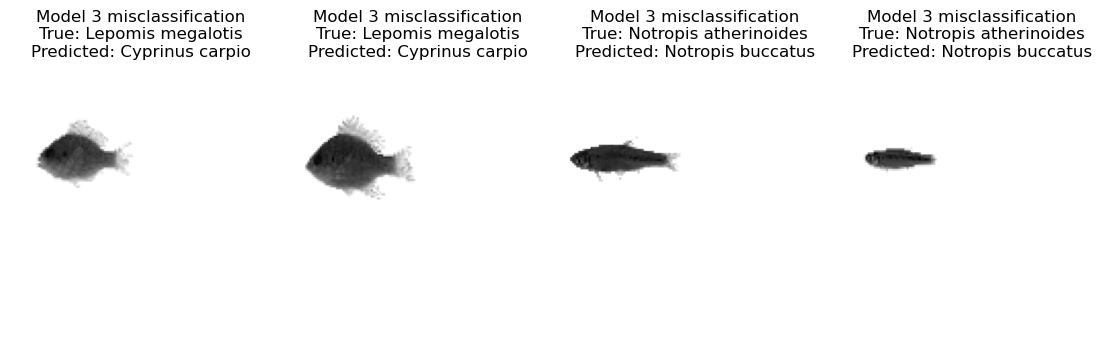

1/1 [==============================] - 0s 91ms/step

Model 4 accuracy: 90.00%
Accuracy by class:
Cyprinus carpio: 100.00%
Esox americanus: 100.00%
Lepomis megalotis: 75.00%
Notropis atherinoides: 75.00%
Notropis buccatus: 100.00%


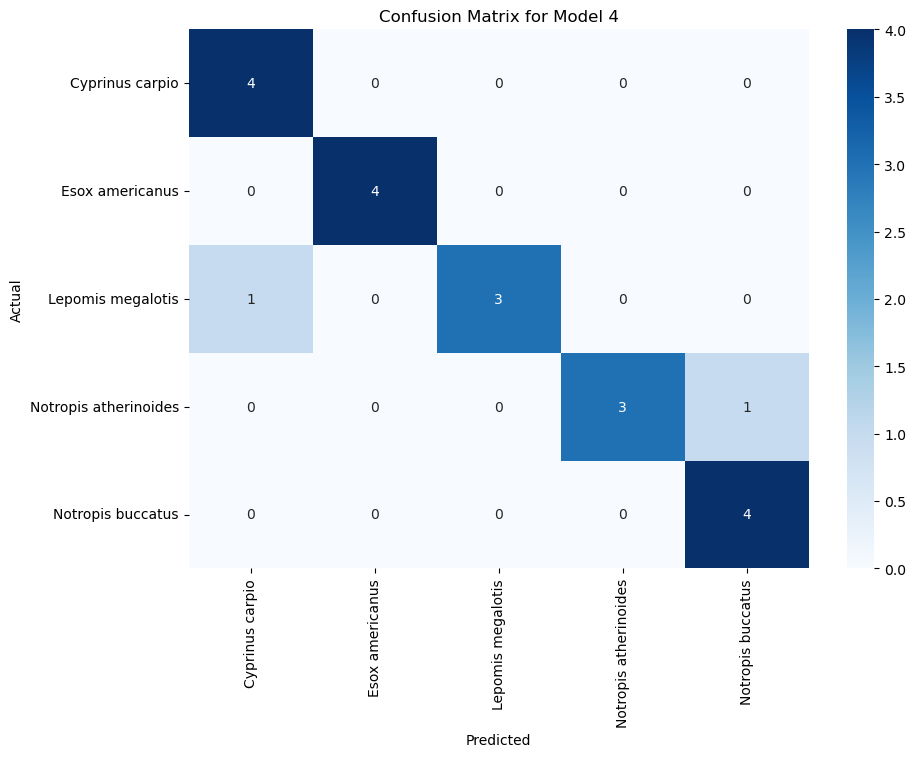

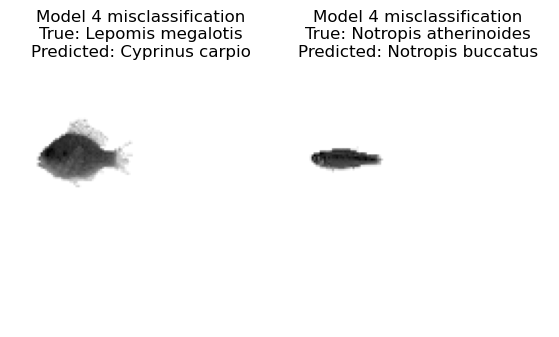

1/1 [==============================] - 0s 138ms/step

Model 5 accuracy: 70.00%
Accuracy by class:
Cyprinus carpio: 100.00%
Esox americanus: 100.00%
Lepomis megalotis: 50.00%
Notropis atherinoides: 50.00%
Notropis buccatus: 50.00%


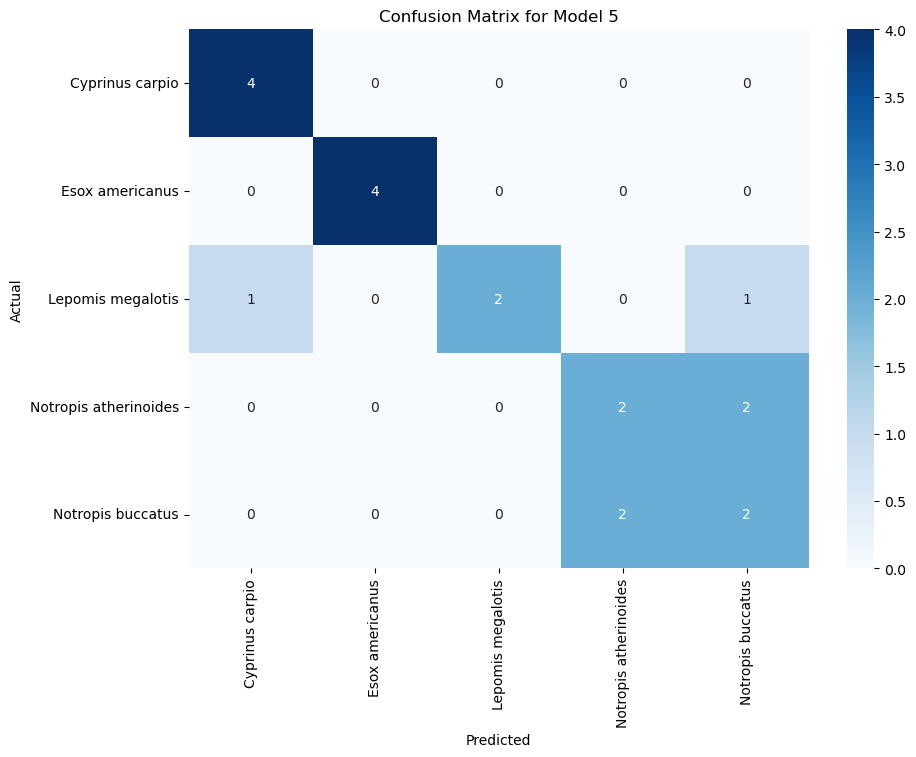

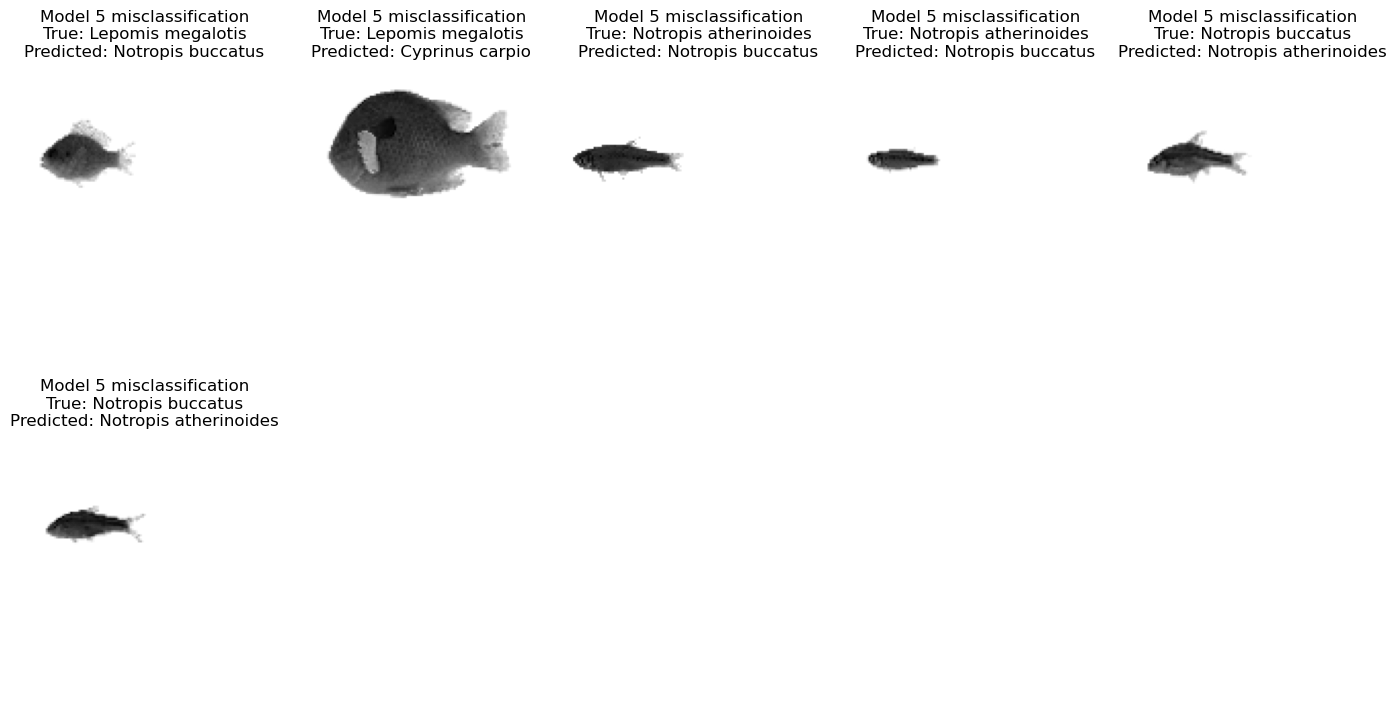


Average accuracy by class:
Cyprinus carpio: 100.00%
Esox americanus: 100.00%
Lepomis megalotis: 75.00%
Notropis atherinoides: 60.00%
Notropis buccatus: 90.00%


In [14]:
def plot_misclassified_images(X_val, y_true, y_pred, class_names, model_number):
    misclassified_indices = np.where(y_true != y_pred)[0]
    n = len(misclassified_indices)
    plt.figure(figsize=(14, 4 * ((n // 5) + 1)))

    for i, idx in enumerate(misclassified_indices):
        plt.subplot(n // 5 + 1, 5, i + 1)
        plt.imshow(X_val[idx], cmap="gray")
        plt.title(f"Model {model_number} misclassification\nTrue: {class_names[y_true[idx]]}\nPredicted: {class_names[y_pred[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()   
    

model_number = 1  
class_accuracies = []  # list to store class accuracies

for model in models:
    class_names = list(label_dict.keys())
    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred)

    # calculating model accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"\nModel {model_number} accuracy: {accuracy * 100:.2f}%")
    
    # calculating model accuracy for each class
    print("Accuracy by class:")
    class_acc = cm.diagonal() / cm.sum(axis=1)
    class_accuracies.append(class_acc)  # adding classes accuracy in a list for averaging
    
    for i, acc in enumerate(class_acc):
        print(f"{class_names[i]}: {acc * 100:.2f}%")
    
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Model {model_number}')
    plt.show()   

    plot_misclassified_images(X_val, y_true, y_pred, class_names, model_number)
    
    # increment the counter
    model_number += 1

# Calculating average of scores by classes

In [ ]:
# calculating and printing average of accuracy by class
mean_class_accuracies = np.mean(class_accuracies, axis=0)
print("\nAverage accuracy by class:")
for i, acc in enumerate(mean_class_accuracies):
    print(f"{class_names[i]}: {acc * 100:.2f}%")


In [15]:
# Data augmentation only in training dataset
train_datagen = ImageDataGenerator(
    preprocessing_function=custom_brightness_adjustment, 
    rotation_range=5,        # Rotação aleatória de até 5 graus
    width_shift_range=0.1,    # Deslocamento horizontal aleatório
    height_shift_range=0.05,   # Deslocamento vertical aleatório       
    horizontal_flip=False,     # Inverter aleatoriamente as imagens horizontalmente
    vertical_flip=False,
    zoom_range=0.05,           # apply zoom    
    fill_mode='nearest'       # Modo de preenchimento para áreas fora da imagem original
)


# create a generator
train_generator_plot = train_datagen.flow(X, y, batch_size=100)


# See all transformations generated by the data augmentation function

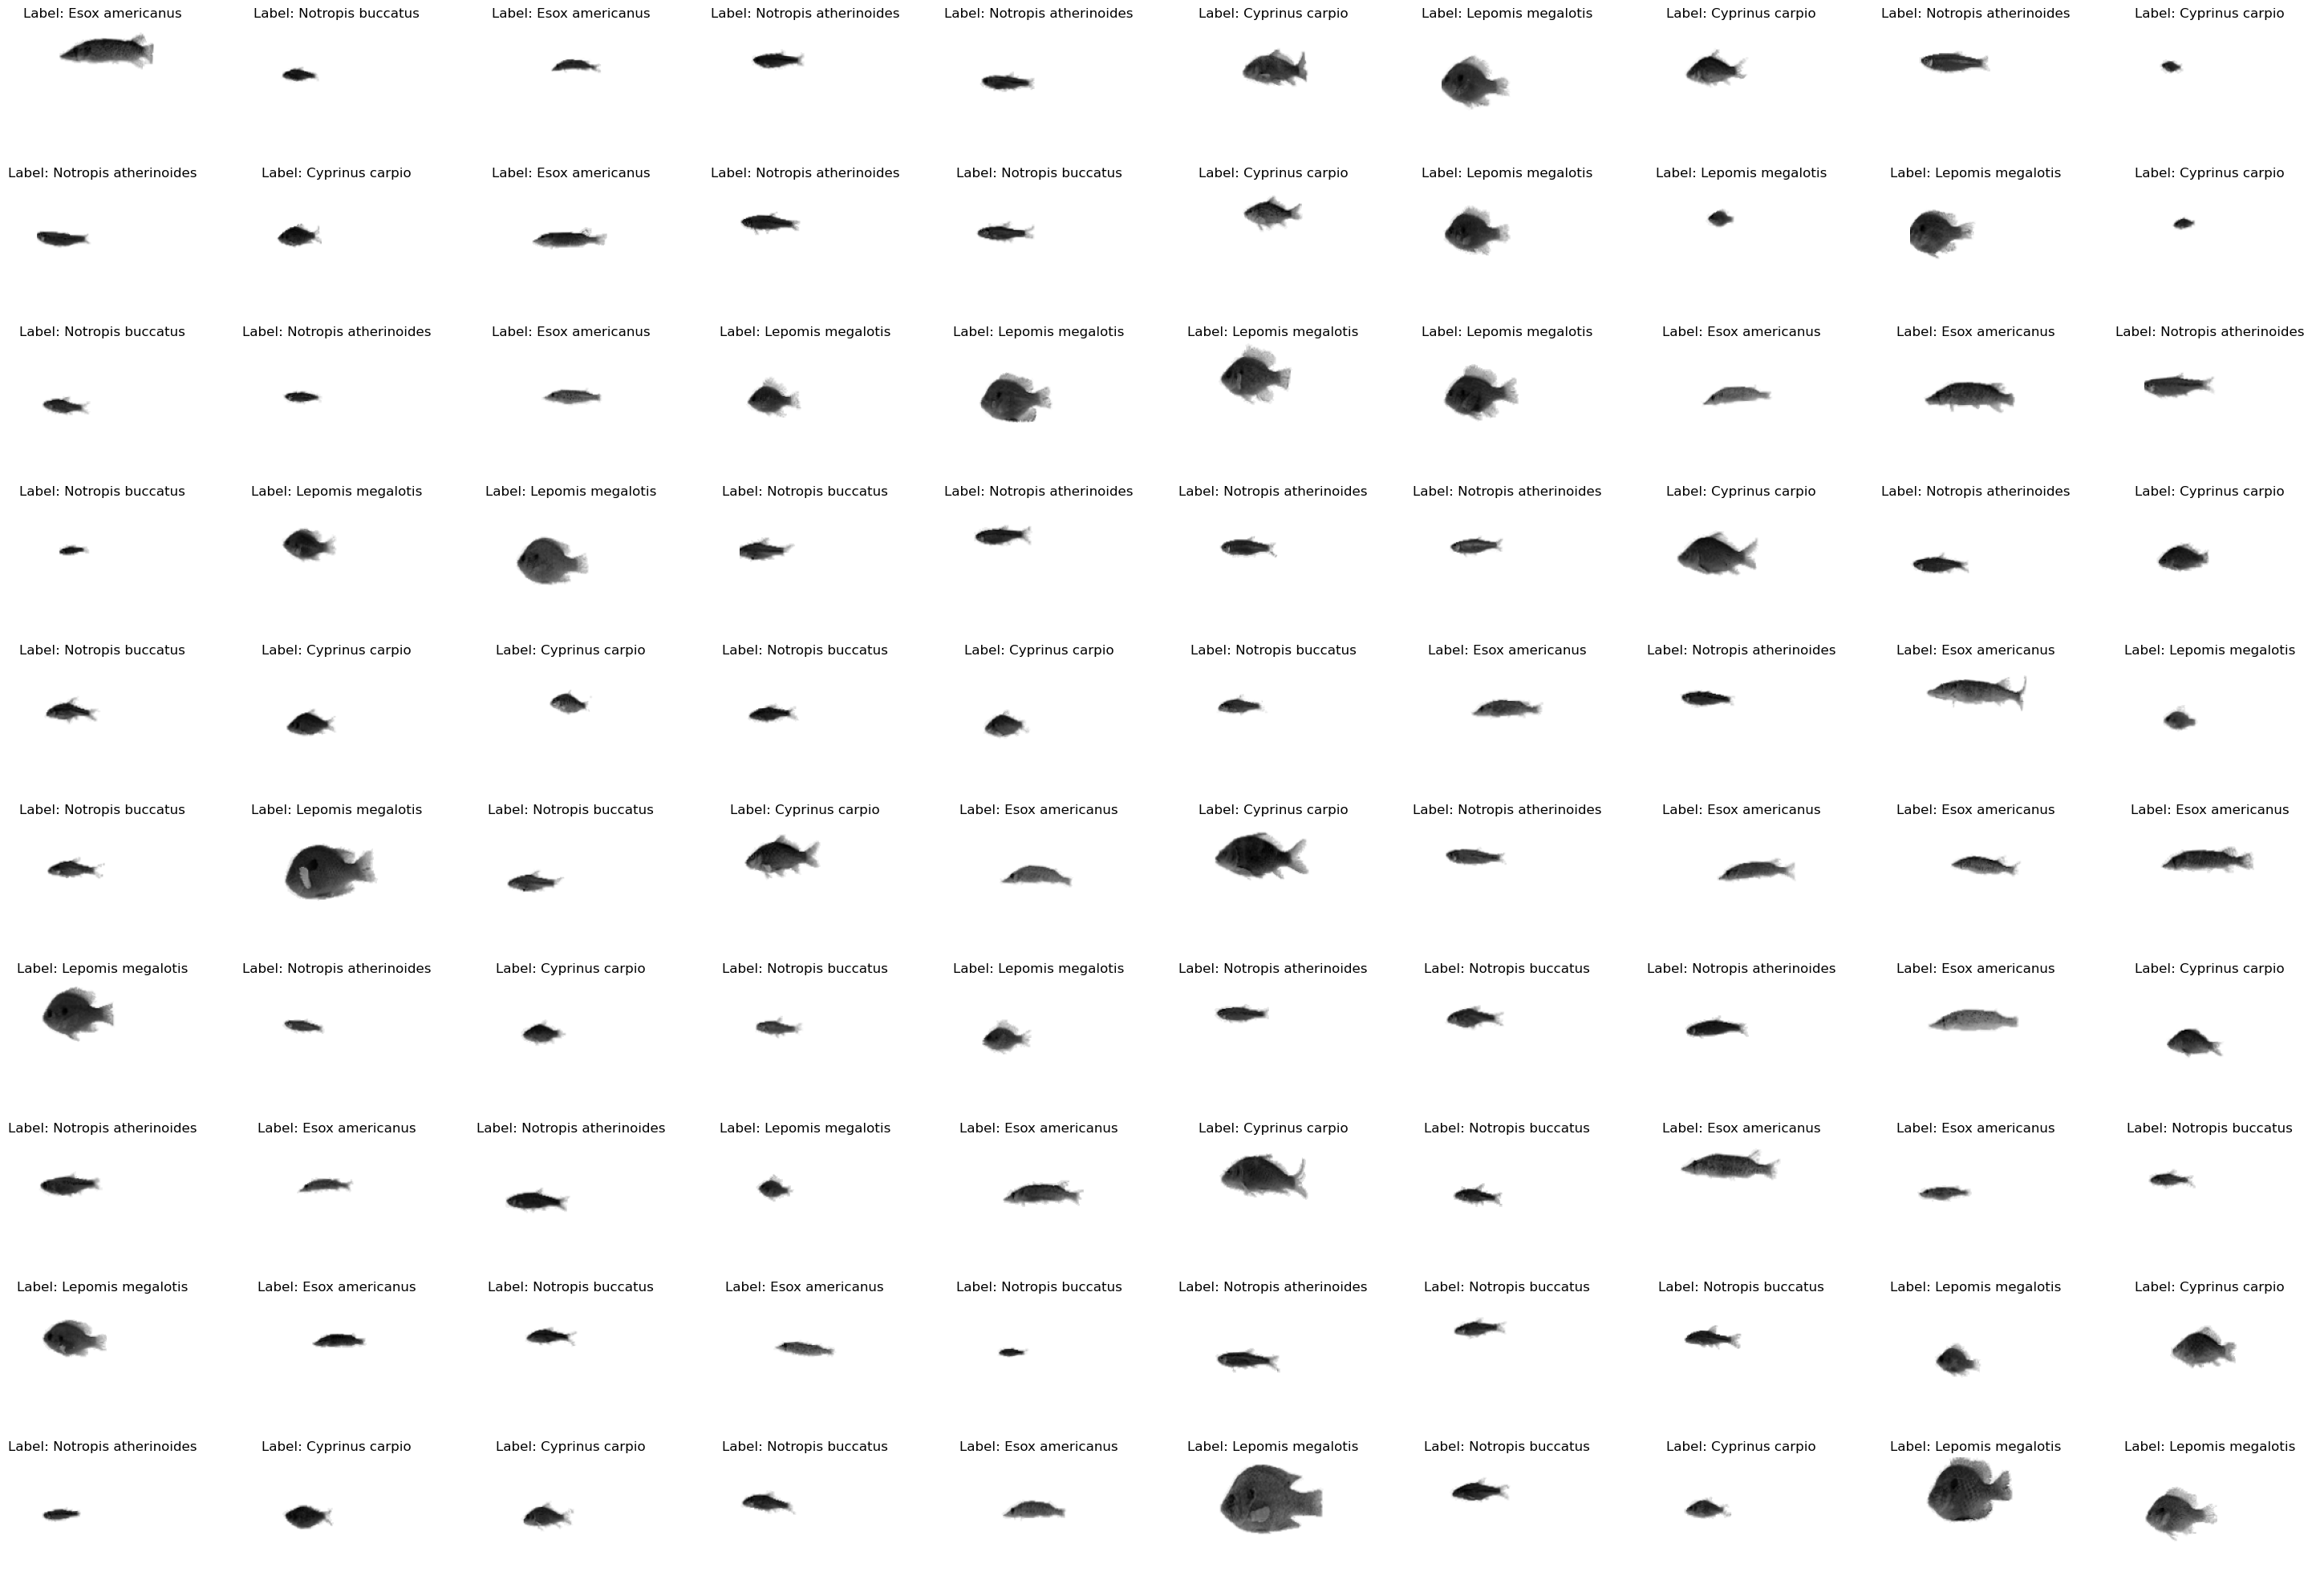

In [16]:
def onehot_to_name(label, label_dict):
    # find maximum indice
    index = np.argmax(label)
    # use the index to find specie name in the dictionary
    for name, idx in label_dict.items():
        if idx == index:
            return name
import matplotlib.pyplot as plt

# get a image batch

total_images = 100
batch_size = 10
num_batches = total_images // batch_size


all_images = []
all_labels = []

for _ in range(num_batches):
    images, labels = next(train_generator_plot)
    all_images.extend(images)
    all_labels.extend(labels)

# all_images and all_labels contains images and labels of all batches

num_rows = 10
num_cols = 10
num_images_to_show = num_rows * num_cols

plt.figure(figsize=(30, 20))  # adjust image size

for i in range(num_images_to_show):

    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(all_images[i], cmap="gray")
    species_name = onehot_to_name(all_labels[i], label_dict)
    plt.title(f"Label: {species_name}")
    plt.axis('off')
plt.tight_layout()
plt.show()
